In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bi-directional-gru-ltspice-example/Data !fig24_31_1/Validation/10.txt
/kaggle/input/bi-directional-gru-ltspice-example/Data !fig24_31_1/Validation/7.txt
/kaggle/input/bi-directional-gru-ltspice-example/Data !fig24_31_1/Validation/8.txt
/kaggle/input/bi-directional-gru-ltspice-example/Data !fig24_31_1/Validation/9.txt
/kaggle/input/bi-directional-gru-ltspice-example/Data !fig24_31_1/Validation/1.txt
/kaggle/input/bi-directional-gru-ltspice-example/Data !fig24_31_1/Validation/14.txt
/kaggle/input/bi-directional-gru-ltspice-example/Data !fig24_31_1/Validation/12.txt
/kaggle/input/bi-directional-gru-ltspice-example/Data !fig24_31_1/Validation/2.txt
/kaggle/input/bi-directional-gru-ltspice-example/Data !fig24_31_1/Validation/4.txt
/kaggle/input/bi-directional-gru-ltspice-example/Data !fig24_31_1/Validation/6.txt
/kaggle/input/bi-directional-gru-ltspice-example/Data !fig24_31_1/Test/3.txt
/kaggle/input/bi-directional-gru-ltspice-example/Data !fig24_31_1/Test/10.txt
/kaggle/inpu

In [2]:

# ================================================================
# 1)  LIBS
# ================================================================
import os, gc, time
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from numpy import loadtxt
from scipy.interpolate import InterpolatedUnivariateSpline
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint

2026-02-14 09:35:15.561641: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1771061715.935388      25 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1771061716.059768      25 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1771061716.969496      25 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771061716.969540      25 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771061716.969543      25 computation_placer.cc:177] computation placer alr

In [3]:
# ================================================================
# 2)  DATA HELPERS  (single, clean set)
# ================================================================
def read_split(path):
    """Read all txt files: columns are t, in1, in2, out."""
    X, Y, T = [], [], []
    mins, maxs = {'in1':[], 'in2':[], 'out':[]}, {'in1':[], 'in2':[], 'out':[]}
    for fn in sorted(os.listdir(path)):
        fp = os.path.join(path, fn)
        if not os.path.isfile(fp):
            continue
        # Read all columns and then select the specified ones
        data = np.loadtxt(fp, unpack=True, skiprows=1)
        # Assuming 1st column is time, 2nd and 3rd are inputs, and 12th is output
        t = data[0]
        in1 = data[1]
        in2 = data[2]
        # The original code expected 12 columns (index 11), but only 5 were found.
        # Assuming 'out' is now the 5th column (index 4). Please verify.
        out = data[3] # Changed from data[3] to data[4] based on data structure

        # --- FIX: Check for NaNs and skip file if found ---
        if np.any(np.isnan(in1)) or np.any(np.isnan(in2)) or np.any(np.isnan(out)):
            print(f"Warning: Skipping file {fn} in {path} due to NaN values.")
            continue
        # --------------------------------------------------

        X.append(np.stack([in1, in2], axis=-1))   # (L,2)
        Y.append(out.reshape(-1,1))               # (L,1)
        T.append(t)
        for k, v in zip(['in1','in2','out'], [in1,in2,out]):
            mins[k].append(v.min()); maxs[k].append(v.max())
    return X, Y, T, mins, maxs

def normalize(X, Y, gmins, gmaxs):
    """Scale to [0,1] using global mins/maxs from TRAIN only."""
    imin = np.array([gmins['in1'], gmins['in2']], dtype=np.float32)
    imax = np.array([gmaxs['in1'], gmaxs['in2']], dtype=np.float32)
    omin = np.float32(gmins['out'])
    omax = np.float32(gmaxs['out'])

    Xn, Yn = [], []
    for x, y in zip(X, Y):
        x = np.asarray(x, dtype=np.float32)
        y = np.asarray(y, dtype=np.float32)
        # Handle cases where imax - imin might be zero to avoid division by zero
        # If max and min are the same, the feature is constant, so normalize to 0.5 (mid-point)
        # or some other sensible constant, or skip if the range is 0.
        # For now, let's assume valid ranges due to NaN filtering.
        Xn.append((x - imin) / (imax - imin))
        Yn.append((y - omin) / (omax - omin))
    return Xn, Yn

def resample(seq, L, kind):
    """Quadratic spline resample to fixed length L."""
    xo = np.arange(len(seq))
    xn = np.linspace(0, len(seq)-1, L)
    if kind == 'xy':
        return np.stack([InterpolatedUnivariateSpline(xo, seq[:,c], k=2)(xn)
                         for c in range(2)], axis=-1)
    return InterpolatedUnivariateSpline(xo, seq[:,0], k=2)(xn).reshape(-1,1)

def resample_split(X, Y, T, L):
    Xr, Yr, Tr = [], [], []
    for x, y, t in zip(X, Y, T):
        Xr.append(resample(x, L, 'xy'))
        Yr.append(resample(y, L, 'y'))
        Tr.append(resample(t.reshape(-1,1), L, 'y').ravel())
    return map(np.asarray, (Xr, Yr, Tr))

In [4]:

# ================================================================
# 3)  PATHS
# ================================================================
train_dir = '/kaggle/input/bi-directional-gru-ltspice-example/Data !fig24_31_1/Train'
val_dir   = '/kaggle/input/bi-directional-gru-ltspice-example/Data !fig24_31_1/Validation'
test_dir  = '/kaggle/input/bi-directional-gru-ltspice-example/Data !fig24_31_1/Test'


In [5]:
import os

# ================================================================
# 4)  LOAD & PREPROCESS (unconstrained)
# ================================================================
Xtr_raw, Ytr_raw, Ttr_raw, mins_tr, maxs_tr = read_split(train_dir)
Xva_raw, Yva_raw, Tva_raw, *_               = read_split(val_dir)
Xte_raw, Yte_raw, Tte_raw, *_               = read_split(test_dir)

gmins = {k: np.min(mins_tr[k]) for k in mins_tr}
gmaxs = {k: np.max(maxs_tr[k]) for k in maxs_tr}

Xtr_n, Ytr_n = normalize(Xtr_raw, Ytr_raw, gmins, gmaxs)
Xva_n, Yva_n = normalize(Xva_raw, Yva_raw, gmins, gmaxs)
Xte_n, Yte_n = normalize(Xte_raw, Yte_raw, gmins, gmaxs)

SEQ_LEN = 600
Xtr, Ytr, Ttr = resample_split(Xtr_n, Ytr_n, Ttr_raw, SEQ_LEN)
Xva, Yva, Tva = resample_split(Xva_n, Yva_n, Tva_raw, SEQ_LEN)
Xte, Yte, Tte = resample_split(Xte_n, Yte_n, Tte_raw, SEQ_LEN)

# Explicitly cast NumPy arrays to float32 to prevent type mismatch with TensorFlow
Xtr = np.array(Xtr, dtype=np.float32)
Ytr = np.array(Ytr, dtype=np.float32)
Xva = np.array(Xva, dtype=np.float32)
Yva = np.array(Yva, dtype=np.float32)
Xte = np.array(Xte, dtype=np.float32)
Yte = np.array(Yte, dtype=np.float32)

Xtr_tf = tf.constant(Xtr, dtype=tf.float32)
Ytr_tf = tf.constant(Ytr, dtype=tf.float32)
Xva_tf = tf.constant(Xva, dtype=tf.float32)
Yva_tf = tf.constant(Yva, dtype=tf.float32)
Xte_tf = tf.constant(Xte, dtype=tf.float32)
Yte_tf = tf.constant(Yte, dtype=tf.float32)

n_steps, n_inputs = SEQ_LEN, 2
d_h = 64  # hidden size

I0000 00:00:1771061737.715924      25 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13757 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1771061737.722027      25 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13757 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [6]:
from tensorflow import keras
from tensorflow.keras import layers

# ================================================================
# 5)  PLAIN MODEL (no constraints)  ->  BiGRU version
# ================================================================
def _core_rnn(inp):
    # BiGRU layer 1
    x = layers.Bidirectional(
        layers.GRU(32, return_sequences=True, activation="tanh", recurrent_activation="sigmoid", reset_after=True), # Added reset_after=True
        merge_mode="concat"   # output dim becomes 64 (= 2*32)
    )(inp)

    # BiGRU layer 2
    x = layers.Bidirectional(
        layers.GRU(32, return_sequences=True, activation="tanh", recurrent_activation="sigmoid", reset_after=True), # Added reset_after=True
        merge_mode="concat"
    )(x)

    # per-timestep regression head (same shape behavior as your Dense(1) on sequences)
    y_hat = layers.Dense(1)(x)
    return y_hat, x


def plain_factory():
    inp = keras.Input(shape=(n_steps, n_inputs))
    y_hat, _ = _core_rnn(inp)
    model = keras.Model(inp, y_hat)
    model.compile(
        loss="mse",
        optimizer=keras.optimizers.Adam(1e-3),
        metrics=["mse"]
    )
    return model

In [7]:
import tensorflow as tf

# Build & show
model = plain_factory()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 600, 2)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 600, 64)        │         6,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 600, 64)        │        18,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 600, 1)         │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,793 (100.75 KB)

 Trainable params: 25,793 (100.75 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# ================================================================
# 6)  TRAIN (print update every 20 epochs)
# ================================================================
class EpochPrinter(keras.callbacks.Callback):
    def __init__(self, every=5):
        super().__init__()
        self.every = every
    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.every == 0:
            loss = logs.get("loss", None)
            val_loss = logs.get("val_loss", None)
            print(f"[Epoch {epoch+1}] loss={loss:.4e}, val_loss={val_loss:.4e}")

tf.keras.utils.set_random_seed(42)
tf.keras.backend.clear_session()

ckpt = ModelCheckpoint('plain_seed42.keras',
                       monitor='val_loss', save_best_only=True, verbose=0)

start_train_time = time.perf_counter()
history = model.fit(
    Xtr_tf, Ytr_tf,
    batch_size=16, epochs=20,
    validation_data=(Xva_tf, Yva_tf),
    callbacks=[ckpt, EpochPrinter(every=50)],
    verbose=0   # silence per-epoch logs
)
end_train_time = time.perf_counter()
train_elapsed_s = end_train_time - start_train_time
print(f"\nTotal training time: {train_elapsed_s:.2f} seconds")


I0000 00:00:1771061743.170486      70 cuda_dnn.cc:529] Loaded cuDNN version 91002



Total training time: 9.85 seconds


In [9]:

# ================================================================
# 7)  EVALUATION + PLOTS
# ================================================================
from sklearn.metrics import mean_squared_error

def plot_split(model, split_name, X_split, Y_split, T_split, batch_size=32, show_plots=True):
    y_pred = model.predict(X_split, batch_size=batch_size, verbose=0).squeeze(-1)  # (N, L)
    mse_accum = 0.0
    n = X_split.shape[0]

    for i in range(n):
        yp = y_pred[i]
        yt = np.asarray(Y_split[i]).squeeze()
        if show_plots:
            plt.figure(figsize=(10,4))
            plt.title(f"{split_name} sample {i}")
            plt.plot(T_split[i], yt, label="target", linewidth=2)
            plt.plot(T_split[i], yp, ":", label="NN output", linewidth=2)
            plt.grid(True); plt.legend(); plt.show()
        mse_accum += mean_squared_error(yt, yp)

    avg_mse = mse_accum / n
    print(f"Average MSE on {split_name}: {avg_mse:.4e}")
    return avg_mse


In [10]:

print("\n=== PERFORMANCE ===")
train_mse = plot_split(model, "TRAIN", Xtr_tf, Ytr_tf, Ttr, show_plots=False)
test_mse  = plot_split(model, "TEST",  Xte_tf, Yte_tf, Tte, show_plots=False)

# Single-waveform latency
single_input = Xte_tf[:1]
t0 = time.perf_counter()
_ = model.predict(single_input, verbose=0)
elapsed_ms = (time.perf_counter() - t0) * 1e3
print(f"Inference time (1 waveform): {elapsed_ms:.2f} ms")

# Keras evaluate (consistency check)
tr = model.evaluate(Xtr_tf, Ytr_tf, verbose=0)[1]
va = model.evaluate(Xva_tf, Yva_tf, verbose=0)[1]
te = model.evaluate(Xte_tf, Yte_tf, verbose=0)[1]

print("\n===  MEAN-SQUARED-ERROR  ===")
print("{:>6s} {:>12s} {:>12s} {:>12s}".format("net","train","valid","test"))
print("-"*56)
print(f"{'plain':>6s} {tr:12.4e} {va:12.4e} {te:12.4e}")



=== PERFORMANCE ===
Average MSE on TRAIN: 4.7953e-03
Average MSE on TEST: 4.7012e-03
Inference time (1 waveform): 100.10 ms

===  MEAN-SQUARED-ERROR  ===
   net        train        valid         test
--------------------------------------------------------
 plain   4.7953e-03   5.0672e-03   4.7012e-03


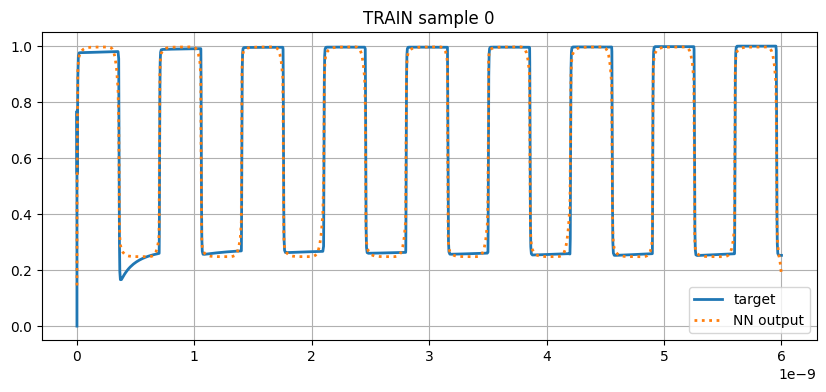

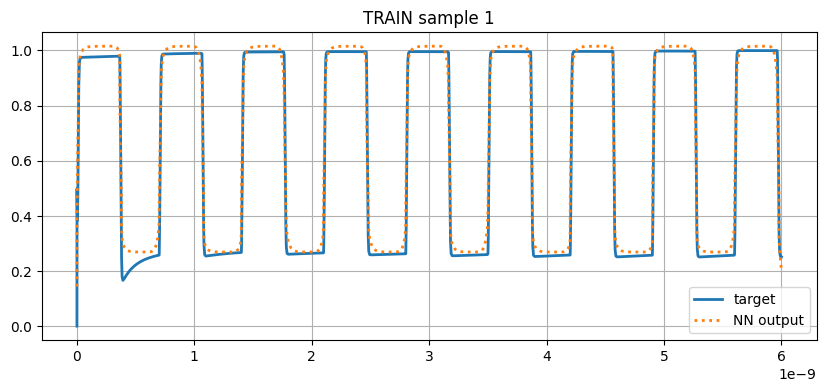

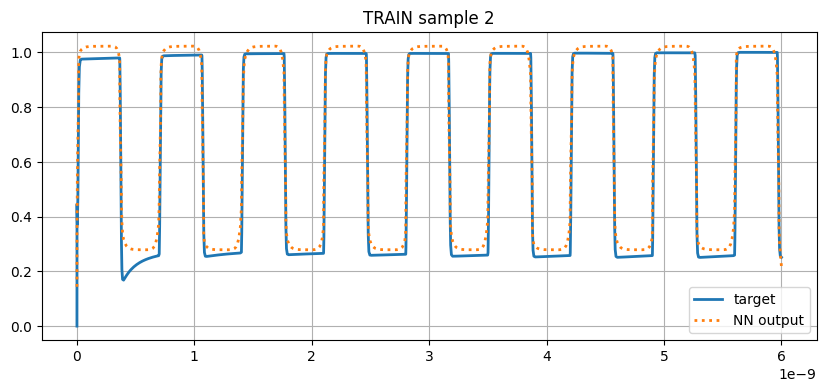

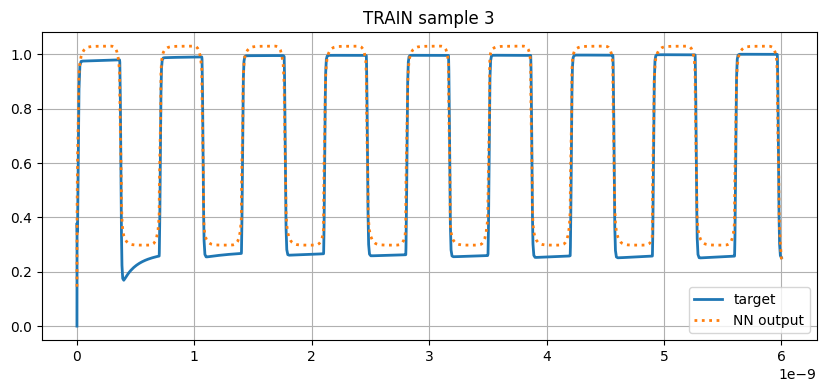

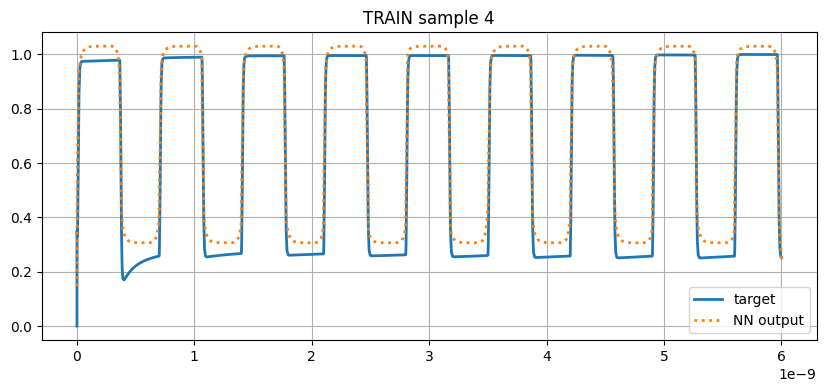

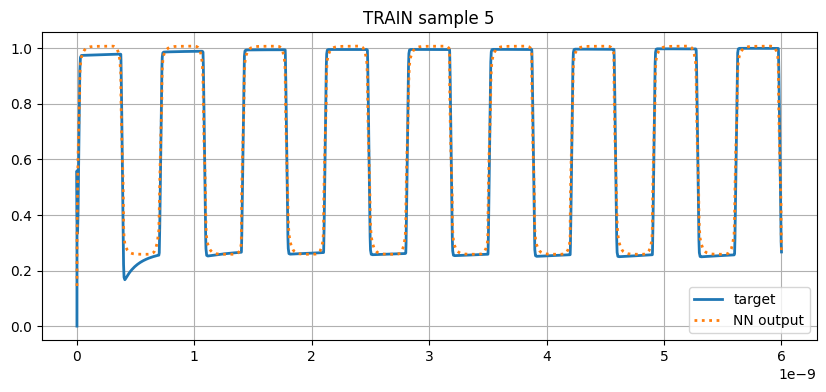

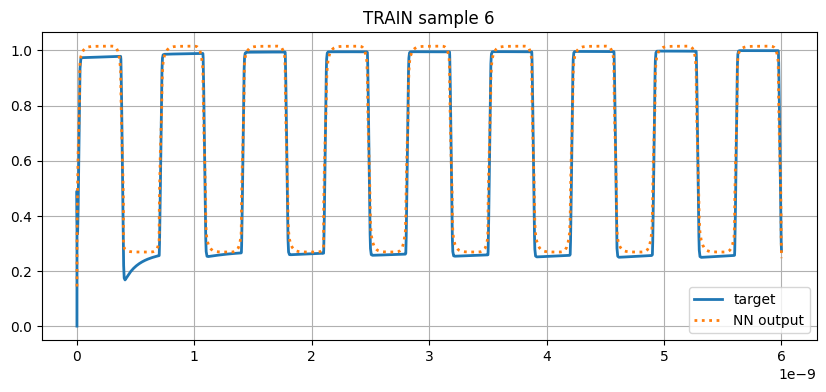

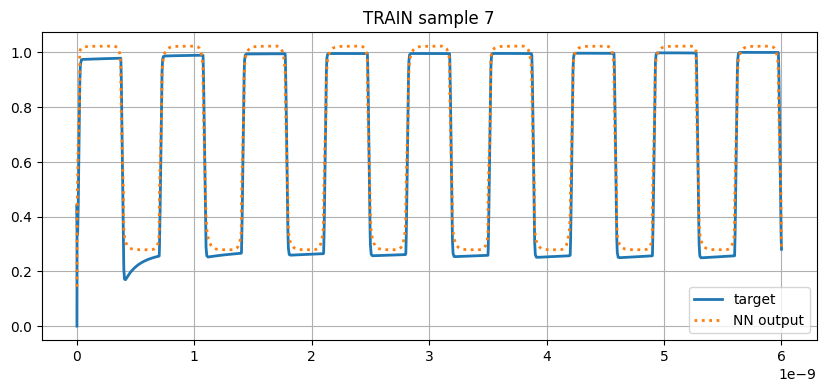

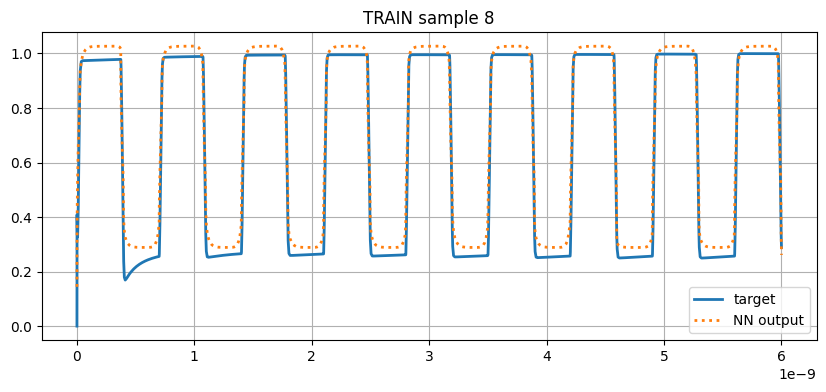

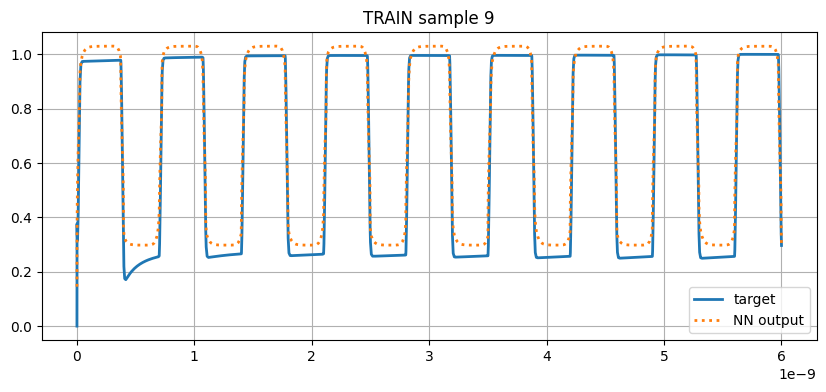

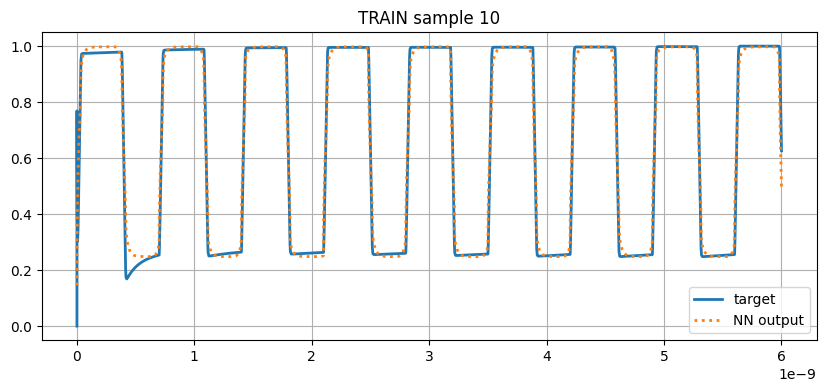

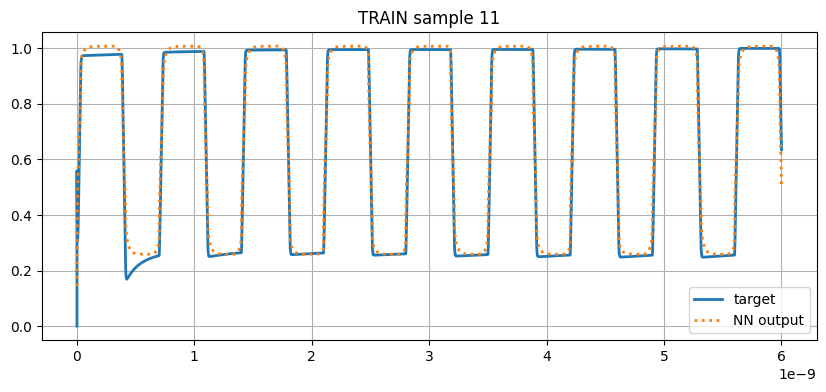

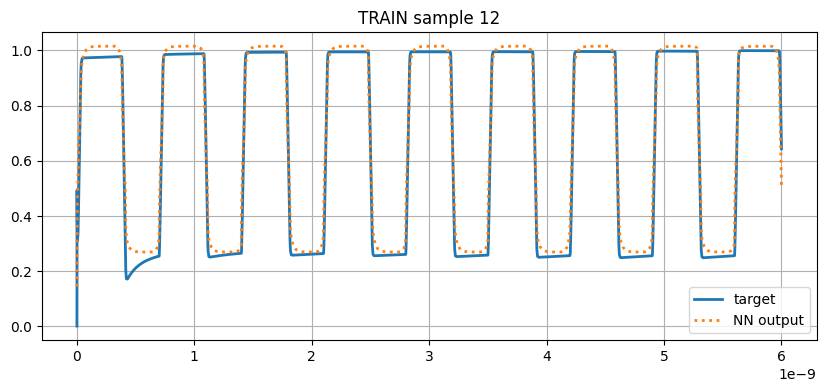

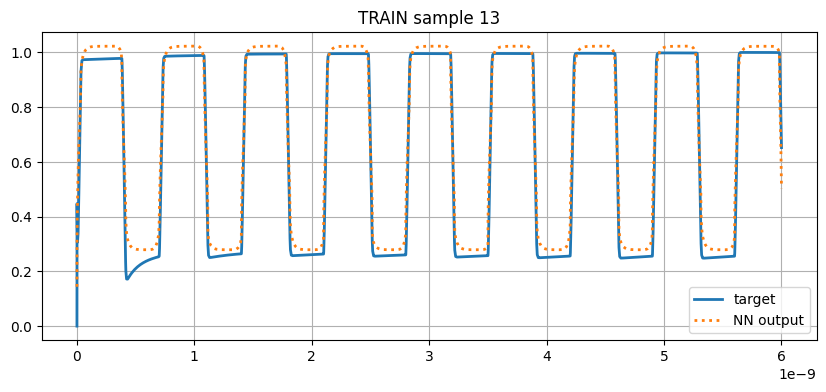

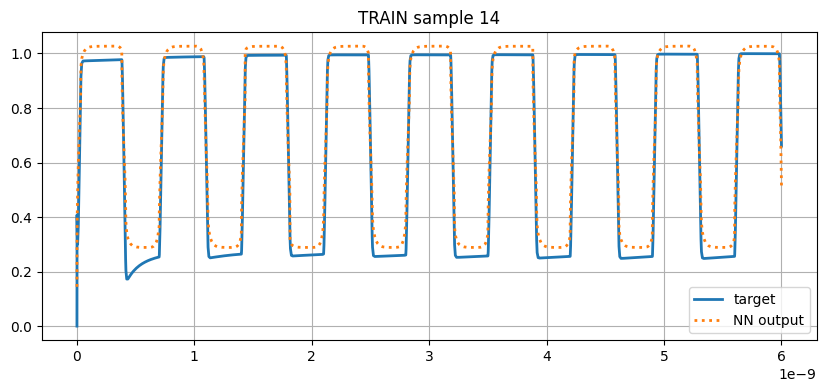

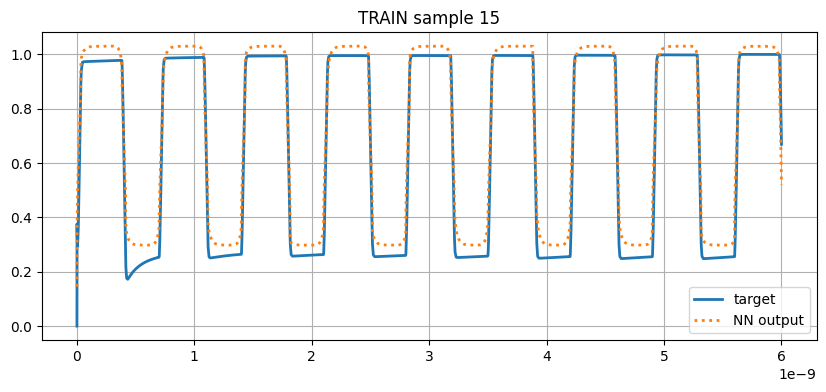

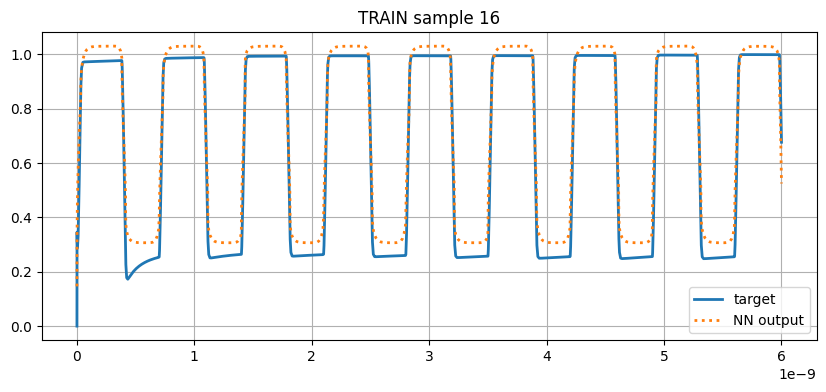

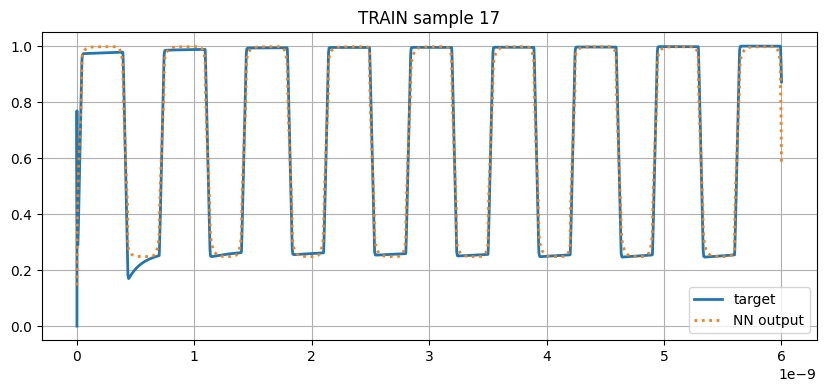

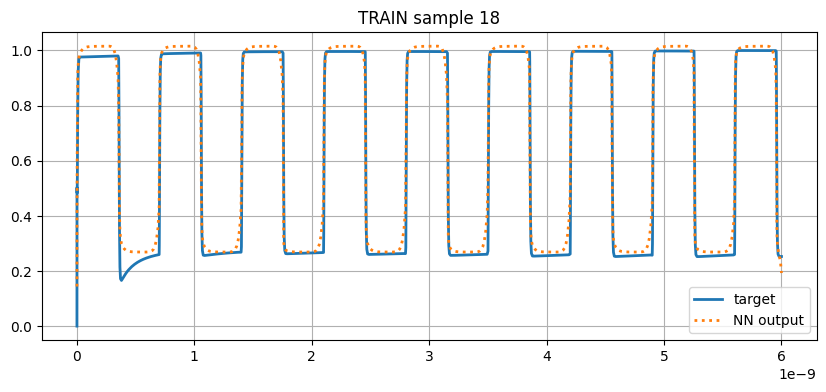

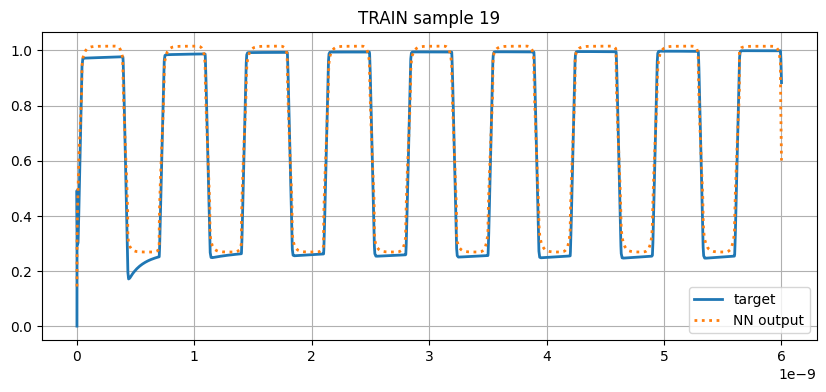

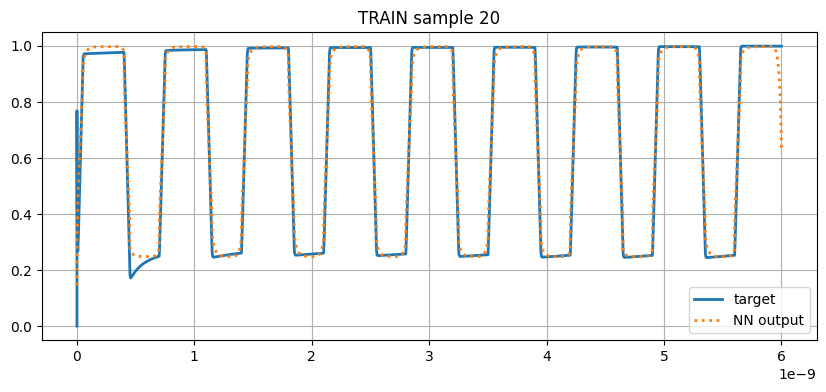

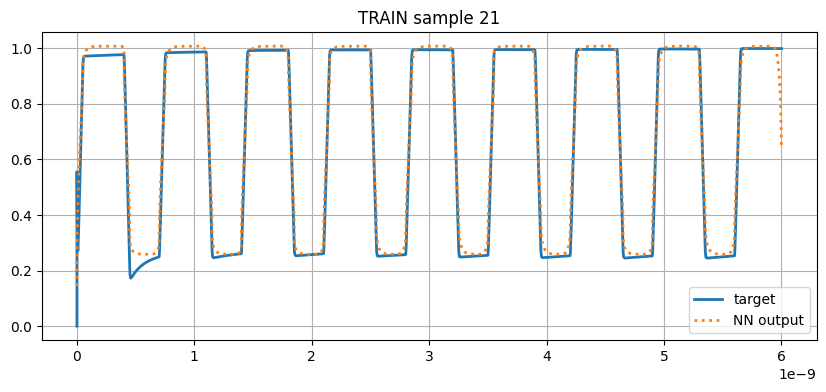

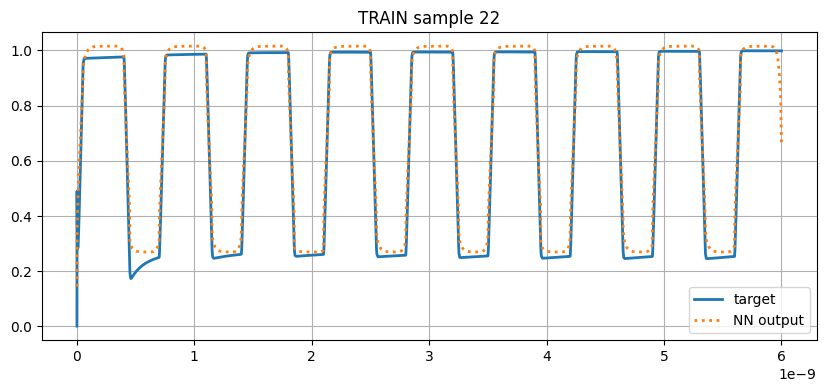

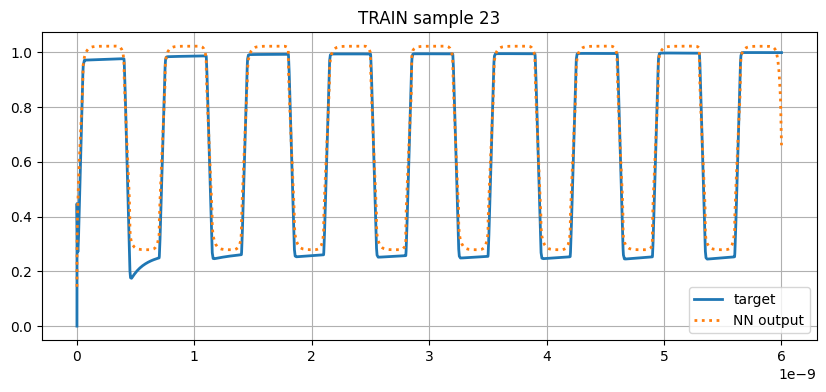

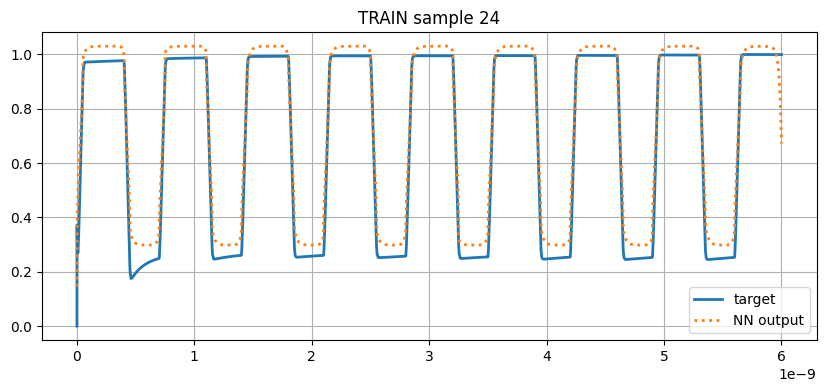

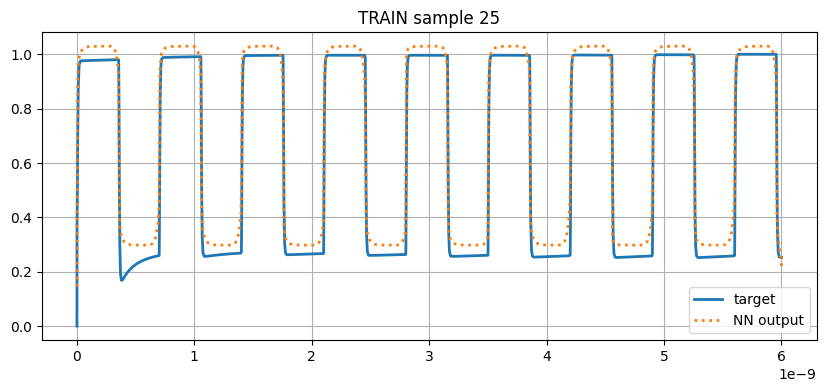

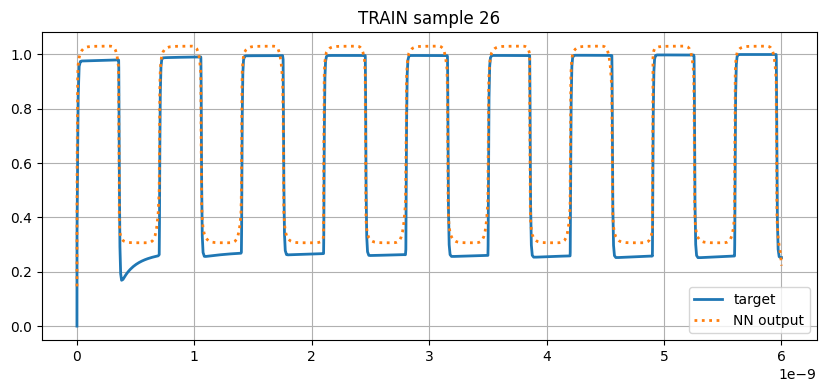

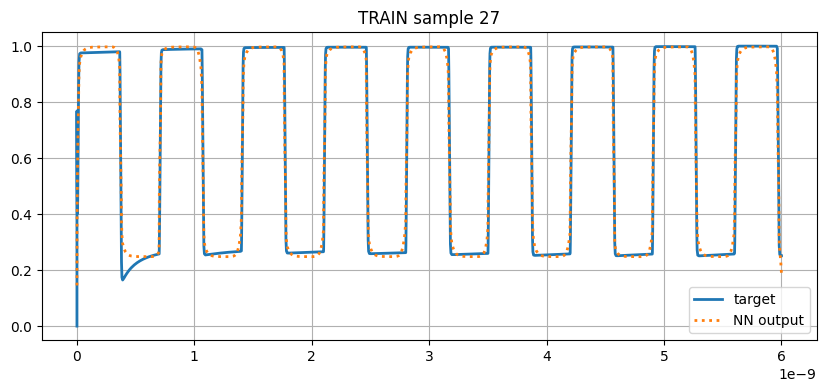

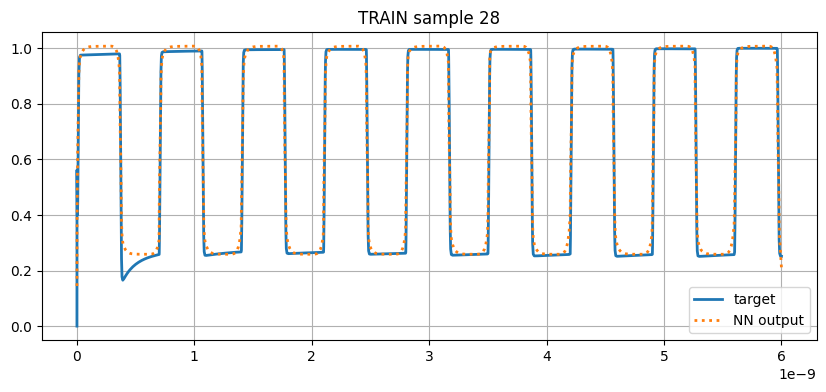

Average MSE on TRAIN: 4.7953e-03


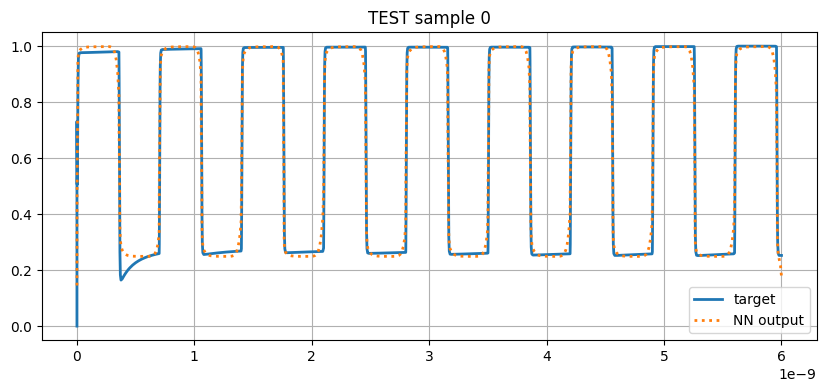

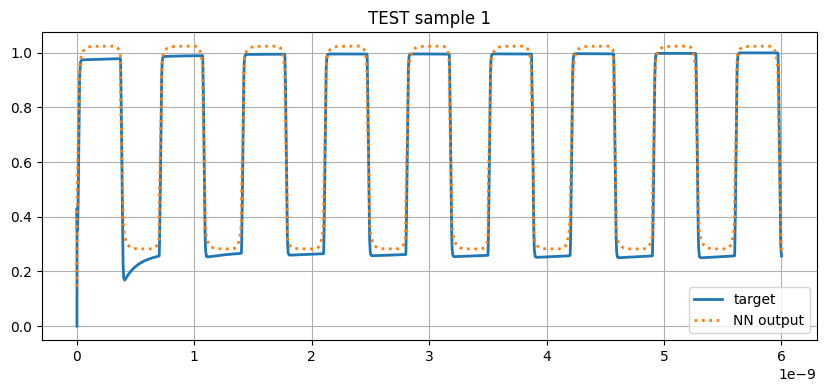

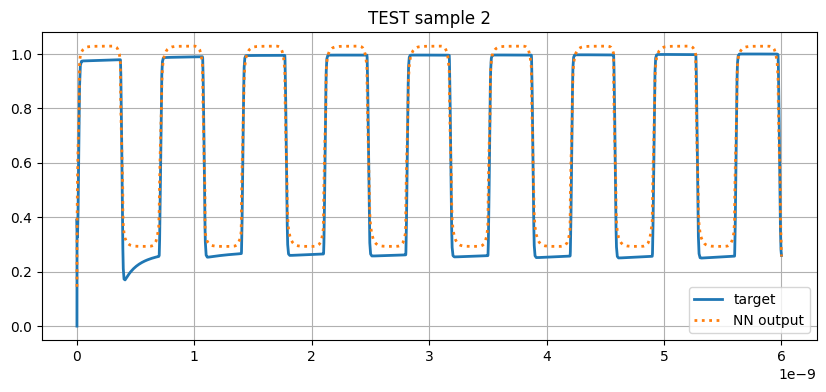

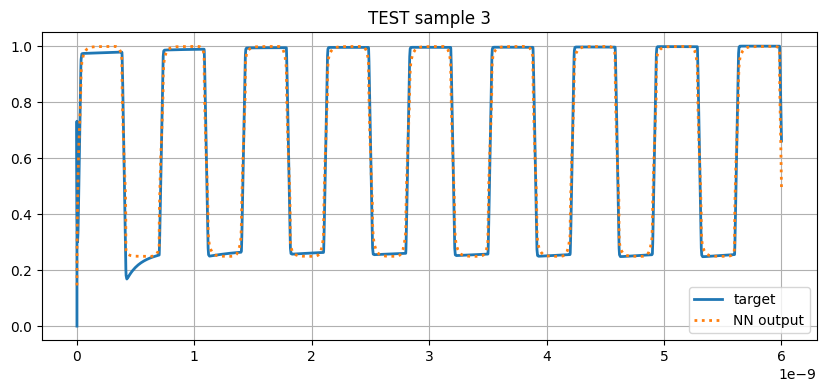

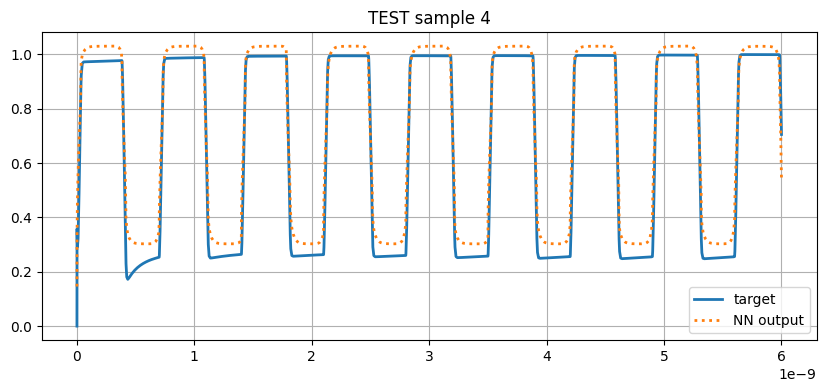

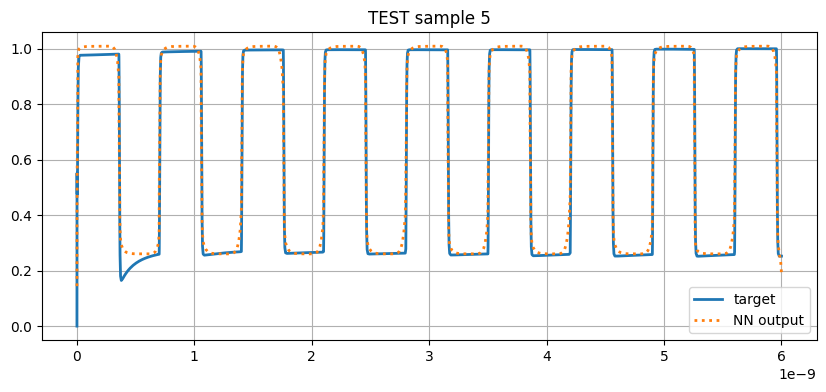

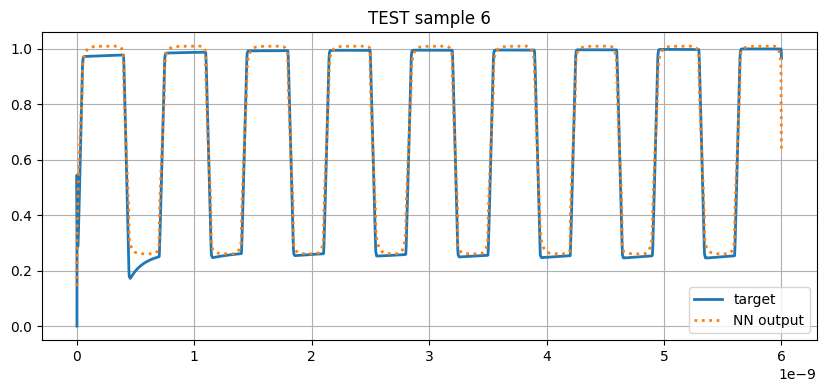

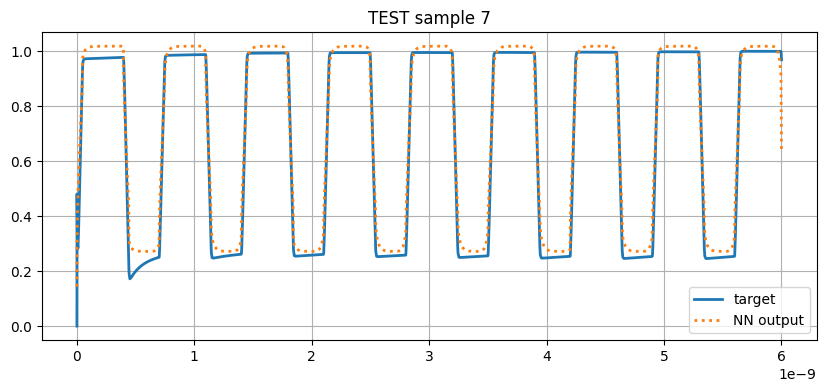

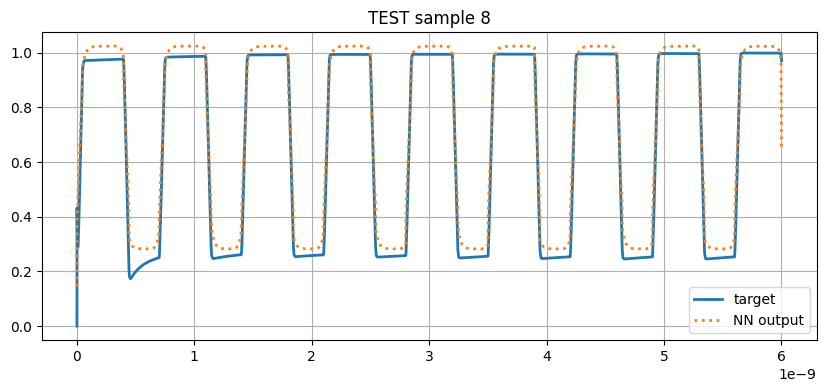

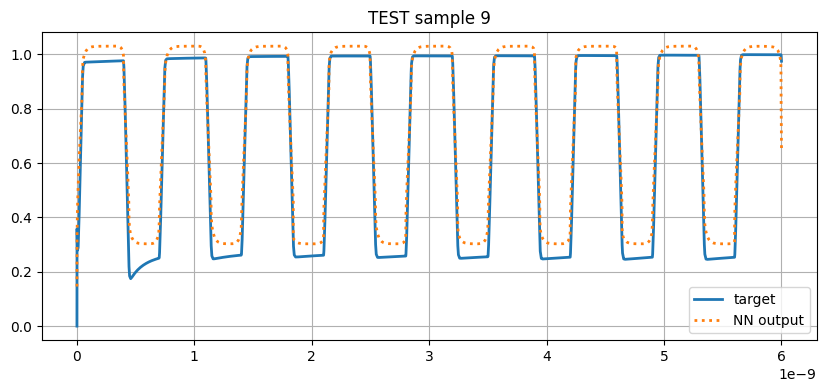

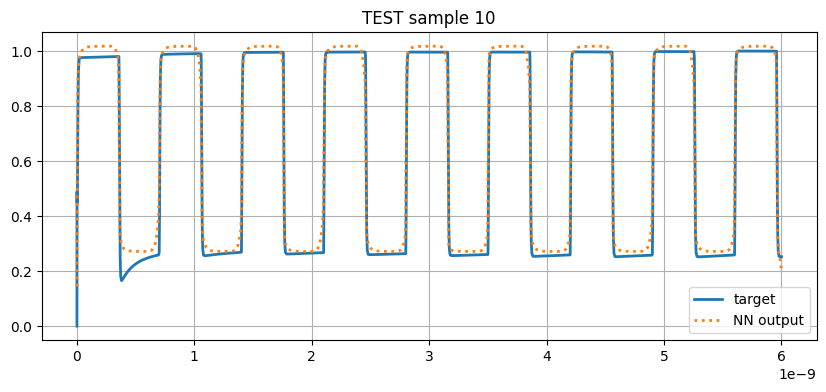

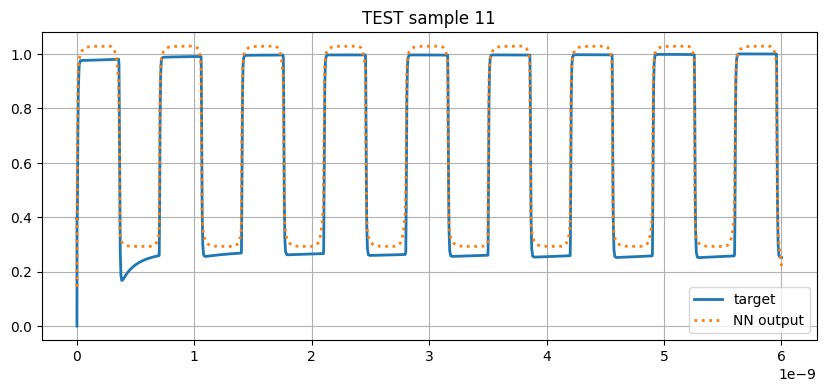

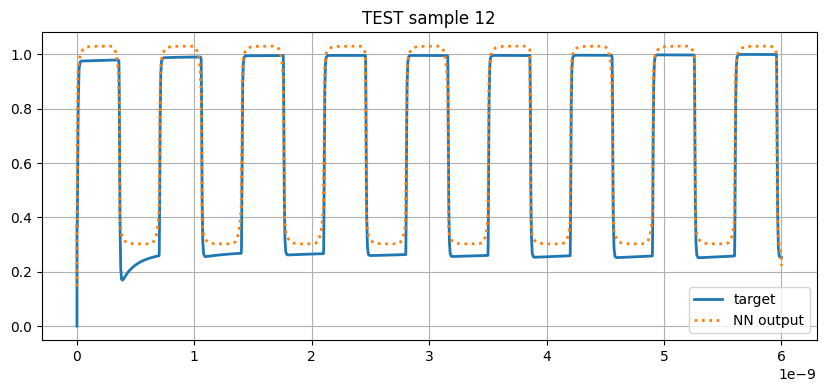

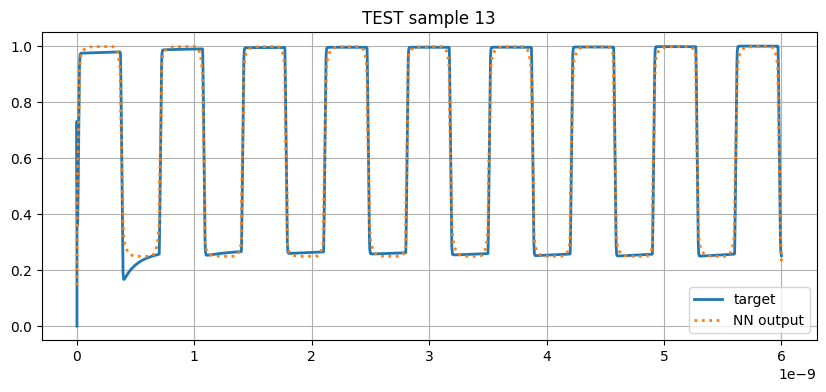

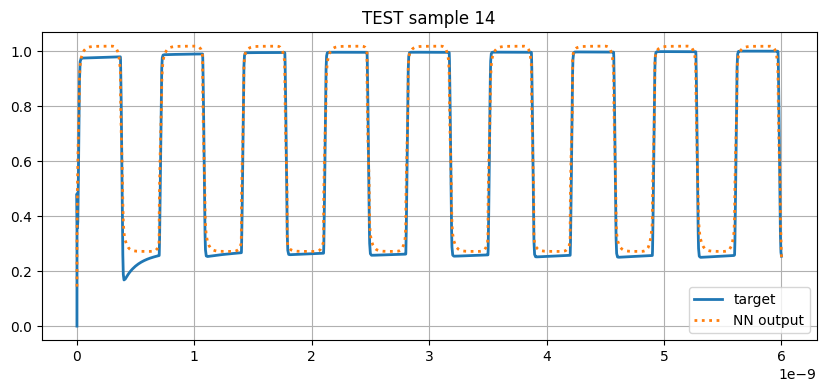

Average MSE on TEST: 4.7012e-03


0.004701241354147593

In [11]:
# Plot some training waveforms
plot_split(model, "TRAIN", Xtr_tf, Ytr_tf, Ttr, show_plots=True)

# Plot some test waveforms
plot_split(model, "TEST", Xte_tf, Yte_tf, Tte, show_plots=True)


=== FGSM ROBUSTNESS (TEST) ===
Clean MSE: 4.7012e-03
     eps      adv_mse        ratio mean|grad|inf
------------------------------------------------------
       0   4.6979e-03       0.9993   8.8377e-05
   0.002   4.7979e-03       1.0206   8.8377e-05
   0.005   4.9535e-03       1.0536   8.8377e-05
    0.01   5.2274e-03       1.1119   8.8377e-05
    0.02   5.8293e-03       1.2399   8.8377e-05
    0.05   8.0632e-03       1.7151   8.8377e-05
     0.1   1.3096e-02       2.7855   8.8377e-05
     0.2   2.6700e-02       5.6793   8.8377e-05


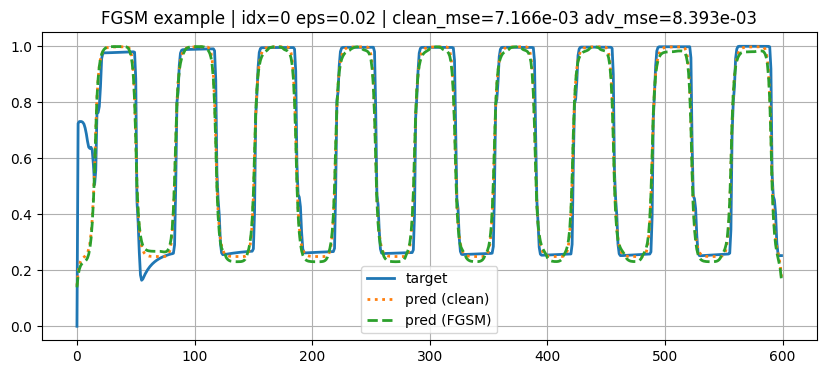

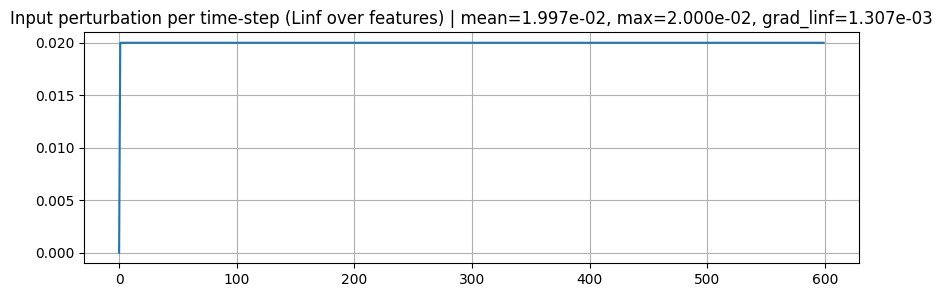

In [12]:
# ================================================================
# 9)  FGSM ADVERSARIAL ROBUSTNESS TEST (inputs -> maximize MSE)
#     - Untargeted FGSM: x_adv = clip(x + eps*sign(dL/dx))
#     - Works for regression / sequence-to-sequence MSE
# ================================================================

def fgsm_attack_batch(model, x, y, eps, clip_min=0.0, clip_max=1.0):
    """
    FGSM for a batch.
    x: [B,T,D]  (should be float32)
    y: [B,T,1]
    Returns:
      x_adv: [B,T,D]
      loss_clean: scalar
      loss_adv: scalar  (computed after crafting x_adv)
      grad_linf: scalar (max |grad|)
    """
    # Ensure inputs are float32
    x = tf.cast(x, dtype=tf.float32)
    y = tf.cast(y, dtype=tf.float32)

    x_var = tf.Variable(x)

    with tf.GradientTape() as tape:
        y_hat = model(x_var, training=False)
        loss = tf.reduce_mean(tf.square(y - y_hat))  # MSE over batch+time
    grad = tape.gradient(loss, x_var)

    # FGSM step
    x_adv = x_var + eps * tf.sign(grad)
    x_adv = tf.clip_by_value(x_adv, clip_min, clip_max)

    # recompute losses
    y_hat_clean = model(x, training=False)
    loss_clean = tf.reduce_mean(tf.square(y - y_hat_clean))

    y_hat_adv = model(x_adv, training=False)
    loss_adv = tf.reduce_mean(tf.square(y - y_hat_adv))

    grad_linf = tf.reduce_max(tf.abs(grad))
    return x_adv, loss_clean, loss_adv, grad_linf


def fgsm_sweep_eval(model, X, Y, eps_list, batch_size=16, clip_min=0.0, clip_max=1.0):
    """
    Evaluate clean MSE and adversarial MSE for a sweep of eps values.
    X, Y can be tf.Tensor or numpy arrays with shapes:
      X: [N,T,D], Y: [N,T,1]
    Returns dict with per-eps metrics.
    """
    # Ensure inputs are float32
    X = tf.cast(X, dtype=tf.float32)
    Y = tf.cast(Y, dtype=tf.float32)

    ds = tf.data.Dataset.from_tensor_slices((X, Y)).batch(batch_size)

    # clean baseline once
    clean_mse_accum, n_batches = 0.0, 0
    for xb, yb in ds:
        yhat = model(xb, training=False)
        clean_mse_accum += tf.reduce_mean(tf.square(yb - yhat))
        n_batches += 1
    clean_mse = float(clean_mse_accum / tf.cast(n_batches, tf.float32))

    results = {"clean_mse": clean_mse, "per_eps": {}}

    for eps in eps_list:
        adv_mse_accum = 0.0
        grad_linf_accum = 0.0
        n_batches = 0

        for xb, yb in ds:
            _, _, loss_adv, grad_linf = fgsm_attack_batch(
                model, xb, yb, eps=float(eps), clip_min=clip_min, clip_max=clip_max
            )
            adv_mse_accum += loss_adv
            grad_linf_accum += grad_linf
            n_batches += 1

        adv_mse = float(adv_mse_accum / tf.cast(n_batches, tf.float32))
        grad_linf_mean = float(grad_linf_accum / tf.cast(n_batches, tf.float32))

        results["per_eps"][float(eps)] = {
            "adv_mse": adv_mse,
            "mse_ratio_adv_over_clean": adv_mse / (clean_mse + 1e-12),
            "mean_grad_linf": grad_linf_mean,
        }

    return results


def craft_fgsm(model, X, Y, epsilon=0.1, relative=True, eps_floor=1e-12, batch_size=64):
    """
    Create FGSM adversarial examples for the whole dataset.
    - epsilon: if relative=True, scales by per-sample, per-feature std over time.
               if relative=False, used as absolute value.
    Returns: X_adv (same shape as X)
    """
    # Ensure inputs are float32
    X = tf.cast(X, dtype=tf.float32)
    Y = tf.cast(Y, dtype=tf.float32)

    N = tf.shape(X)[0]
    Din = X.shape[-1]
    X_adv_chunks = []

    # Compute per-sample, per-feature std over time for relative scaling
    if relative:
        # std over time axis=1 -> shape (N, 1, Din)
        std_t = tf.math.reduce_std(X, axis=1, keepdims=True) # X is already float32
        eps_abs_full = epsilon * tf.maximum(std_t, eps_floor)
    else:
        eps_abs_full = epsilon

    ds = tf.data.Dataset.from_tensor_slices((X, Y)).batch(batch_size)
    idx = 0
    for xb, yb in ds:
        if relative:
            # slice matching current batch
            eps_b = eps_abs_full[idx: idx + tf.shape(xb)[0]]
        else:
            eps_b = epsilon
        # xb and yb are already tf.float32 from the dataset created from tf.cast(X, tf.float32)
        x_adv_b = _fgsm_batch(model, xb, yb, tf.cast(eps_b, tf.float32))
        X_adv_chunks.append(x_adv_b.numpy())
        idx += tf.shape(xb)[0]
    X_adv = np.concatenate(X_adv_chunks, axis=0)
    return X_adv

def plot_fgsm_example(model, X, Y, sample_idx=0, eps=0.02, clip_min=0.0, clip_max=1.0):
    """
    Plot one sample: clean prediction vs adversarial prediction, plus input perturbation magnitude.
    """
    # Ensure inputs are float32
    x = tf.cast(X[sample_idx:sample_idx+1], dtype=tf.float32)  # [1,T,D]
    y = tf.cast(Y[sample_idx:sample_idx+1], dtype=tf.float32)  # [1,T,1]

    x_adv, loss_clean, loss_adv, grad_linf = fgsm_attack_batch(
        model, x, y, eps=float(eps), clip_min=clip_min, clip_max=clip_max
    )

    yhat_clean = model(x, training=False).numpy().squeeze()
    yhat_adv   = model(x_adv, training=False).numpy().squeeze()
    ytrue      = y.numpy().squeeze()

    dx = (x_adv - x).numpy().squeeze()  # [T,D]
    dx_linf_t = np.max(np.abs(dx), axis=-1)  # [T]

    plt.figure(figsize=(10,4))
    plt.title(f"FGSM example | idx={sample_idx} eps={eps} | clean_mse={float(loss_clean):.3e} adv_mse={float(loss_adv):.3e}")
    plt.plot(ytrue, label="target", linewidth=2)
    plt.plot(yhat_clean, ":", label="pred (clean)", linewidth=2)
    plt.plot(yhat_adv, "--", label="pred (FGSM)", linewidth=2)
    plt.grid(True); plt.legend(); plt.show()

    plt.figure(figsize=(10,3))
    plt.title(f"Input perturbation per time-step (Linf over features) | mean={dx_linf_t.mean():.3e}, max={dx_linf_t.max():.3e}, grad_linf={float(grad_linf):.3e}")
    plt.plot(dx_linf_t, linewidth=1.5)
    plt.grid(True); plt.show()


# ----------------- Run FGSM test on TEST split -----------------
# eps is in your normalized [0,1] input space. Try small values first.
eps_list = [0.0, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2]

fgsm_results = fgsm_sweep_eval(
    model,
    Xte_tf, Yte_tf,
    eps_list=eps_list,
    batch_size=16,
    clip_min=0.0, clip_max=1.0
)

print("\n=== FGSM ROBUSTNESS (TEST) ===")
print(f"Clean MSE: {fgsm_results['clean_mse']:.4e}")
print("{:>8s} {:>12s} {:>12s} {:>12s}".format("eps", "adv_mse", "ratio", "mean|grad|inf"))
print("-"*54)
for eps in eps_list:
    r = fgsm_results["per_eps"][float(eps)]
    print("{:8.3g} {:12.4e} {:12.4f} {:12.4e}".format(
        eps, r["adv_mse"], r["mse_ratio_adv_over_clean"], r["mean_grad_linf"]
    ))

# Plot one illustrative sample
plot_fgsm_example(
    model,
    Xte_tf.numpy(), Yte_tf.numpy(),
    sample_idx=0,
    eps=0.02,
    clip_min=0.0, clip_max=1.0
)
